# The real TezNet

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.models import Sequential
from keras.layers import Input, Dense, Activation,BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense, Multiply, Input, Concatenate, DepthwiseConv2D
from tensorflow.keras.regularizers import l2
from torchsummary import summary

In [3]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((227, 227)),          # Resize the image to 227x227
    transforms.ToTensor(),                  # Convert the image to a tensor
    transforms.RandomHorizontalFlip(),      # Randomly flip the image horizontally
    transforms.RandomResizedCrop(227, scale=(0.8, 1.2)),  # Randomly crop the image
    transforms.RandomRotation(20),          # Randomly rotate the image
    transforms.ColorJitter(brightness=(0.75, 1.5))  # Randomly change the brightness
])


In [4]:
# Load datasets
train_path = "OCTDataset/OCT2017Unique/kaggle/working/OCTDataset/OCT2017UniqueSplit/train"
test_path = "OCTDataset/OCT2017Unique/kaggle/working/OCTDataset/OCT2017UniqueSplit/test"


In [92]:
train_dataset = datasets.ImageFolder(train_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

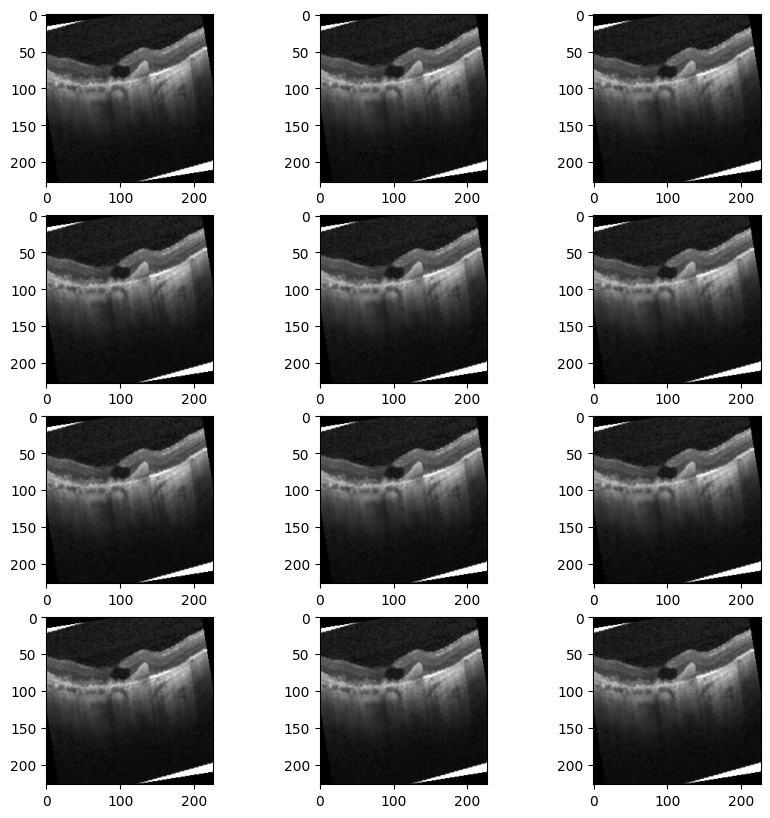

In [6]:
# Visualize some training images
fig, axs = plt.subplots(4, 3, figsize=(10, 10))
for i, (img, _) in enumerate(train_loader):
    if i == 1: break
    for j in range(4):
        for k in range(3):
            axs[j][k].imshow(img[0].permute(1, 2, 0).numpy())
plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class SqueezeExciteBlock(nn.Module):
    def __init__(self, in_channels, reduction=4):
        super(SqueezeExciteBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        se = self.global_avg_pool(x)
        se = self.relu(self.fc1(se))
        se = self.relu(self.fc2(se))
        se = self.sigmoid(se)
        return x * se

class InceptionBlock(nn.Module):
    def __init__(self, in_channels, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
        super(InceptionBlock, self).__init__()
        self.conv_1x1 = nn.Conv2d(in_channels, filters_1x1, kernel_size=1)

        self.conv_3x3_reduce = nn.Conv2d(in_channels, filters_3x3_reduce, kernel_size=1)
        self.conv_3x3 = nn.Conv2d(filters_3x3_reduce, filters_3x3, kernel_size=3, padding=1)

        self.conv_5x5_reduce = nn.Conv2d(in_channels, filters_5x5_reduce, kernel_size=1)
        self.conv_5x5 = nn.Conv2d(filters_5x5_reduce, filters_5x5, kernel_size=5, padding=2)

        self.pool_proj = nn.Conv2d(in_channels, filters_pool_proj, kernel_size=1)

    def forward(self, x):
        conv_1x1 = F.relu(self.conv_1x1(x))

        conv_3x3 = F.relu(self.conv_3x3(F.relu(self.conv_3x3_reduce(x))))

        conv_5x5 = F.relu(self.conv_5x5(F.relu(self.conv_5x5_reduce(x))))

        pool_proj = F.relu(self.pool_proj(F.max_pool2d(x, kernel_size=3, stride=1, padding=1)))

        return torch.cat([conv_1x1, conv_3x3, conv_5x5, pool_proj], dim=1)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, filters, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = DepthwiseSeparableConv(in_channels, filters, stride)
        self.conv2 = DepthwiseSeparableConv(filters, filters, 1)
        self.se_block = SqueezeExciteBlock(filters)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != filters:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, filters, kernel_size=1, stride=stride),
                nn.BatchNorm2d(filters)
            )
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.se_block(out)
        out = self.conv2(out)
        out = self.se_block(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class Model1(nn.Module):
    def __init__(self, input_shape=(64, 64, 3), num_classes=4):
        super(Model1, self).__init__()
        self.conv1 = nn.Conv2d(input_shape[2], 96, kernel_size=7, stride=2, padding=3)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(96)

        self.conv2 = nn.Conv2d(96, 256, kernel_size=(1, 3), padding=(0, 1))
        self.conv3 = nn.Conv2d(256, 256, kernel_size=(3, 1), padding=(1, 0))
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(256)

        self.res_block2 = ResidualBlock(256, 128)
        self.res_block3 = ResidualBlock(128, 256)

        self.inception1 = InceptionBlock(256, 64, 96, 128, 16, 32, 32)
        self.inception3 = InceptionBlock(256, 64, 96, 128, 16, 32, 32)

        self.res_block4 = ResidualBlock(256, 256, stride=2)
        self.res_block5 = ResidualBlock(256, 512)

        self.inception5 = InceptionBlock(512, 128, 192, 256, 32, 64, 64)
        self.inception6 = InceptionBlock(512, 128, 192, 256, 32, 64, 64)


        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.bn1(x)

        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = self.bn2(x)

        x = self.res_block2(x)
        x = self.res_block3(x)

        x = self.inception1(x)
        x = self.inception3(x)

        x = self.res_block4(x)
        x = self.res_block5(x)

        x = self.inception5(x)
        x = self.inception6(x)


        x = self.pool3(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc3(x)
        return x



In [9]:
# summary(model, input_size=(3, 227, 227))
# summary(model, input_size=(227, 227, 3))
summary(model, input_size=(3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 114, 114]          14,208
         MaxPool2d-2           [-1, 96, 57, 57]               0
       BatchNorm2d-3           [-1, 96, 57, 57]             192
            Conv2d-4          [-1, 256, 57, 57]          73,984
            Conv2d-5          [-1, 256, 57, 57]         196,864
         MaxPool2d-6          [-1, 256, 28, 28]               0
       BatchNorm2d-7          [-1, 256, 28, 28]             512
            Conv2d-8          [-1, 256, 28, 28]           2,560
            Conv2d-9          [-1, 128, 28, 28]          32,896
      BatchNorm2d-10          [-1, 128, 28, 28]             256
             ReLU-11          [-1, 128, 28, 28]               0
DepthwiseSeparableConv-12          [-1, 128, 28, 28]               0
AdaptiveAvgPool2d-13            [-1, 128, 1, 1]               0
           Conv2d-14             [

In [7]:

# Initialize and print the model
# model = Model1(input_shape=(227, 227, 3), num_classes=4, cardinality=32)
model = Model1(input_shape=(227, 227, 3), num_classes=4)
# model = Model1(input_shape=(3, 227, 227), classes=4)
# model = Model1(input_shape=(3, 227, 227), num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-4)
print(model)

# # Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, weight_decay=1e-4, momentum=0.9)
# print(model)


Model1(
  (conv1): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(96, 256, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  (conv3): Conv2d(256, 256, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res_block2): ResidualBlock(
    (conv1): DepthwiseSeparableConv(
      (depthwise): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256)
      (pointwise): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2): DepthwiseSeparableConv(
      (depthw

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,  weight_decay=1e-4)
print(model)

Model1(
  (conv1): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(96, 256, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  (conv3): Conv2d(256, 256, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res_block2): ResidualBlock(
    (conv1): DepthwiseSeparableConv(
      (depthwise): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256)
      (pointwise): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2): DepthwiseSeparableConv(
      (depthw

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import os

# Define the directory where you want to save the model checkpoints
checkpoint_dir = './checkpointsPT-opt2'
os.makedirs(checkpoint_dir, exist_ok=True)

# Training loop
num_epochs = 10
model.to(device)  # Ensure model is on the correct device
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for i, (inputs, labels) in enumerate(train_loader):

        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the correct device
        
        optimizer.zero_grad()  # Zero the parameter gradients
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize the weights
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
        
        # Print statistics every 10 batches
        if i % 10 == 9:
            accuracy = 100 * correct_predictions / total_predictions
            print(f'Epoch {epoch+1}, Batch {i+1}, Loss: {running_loss / 10:.3f}, Accuracy: {accuracy:.2f}%')
            running_loss = 0.0
            correct_predictions = 0
            total_predictions = 0

    # Save the model checkpoint every 5 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch+54}.pth')
        torch.save(model.state_dict(), checkpoint_path)
        print(f'Saved checkpoint: {checkpoint_path}')
    
    # Optionally, you can evaluate on the validation set here if you have one

print('Finished Training')


Epoch 1, Batch 10, Loss: 0.160, Accuracy: 93.75%
Epoch 1, Batch 20, Loss: 0.085, Accuracy: 96.56%
Epoch 1, Batch 30, Loss: 0.143, Accuracy: 94.69%
Epoch 1, Batch 40, Loss: 0.067, Accuracy: 98.12%
Epoch 1, Batch 50, Loss: 0.086, Accuracy: 96.56%
Epoch 1, Batch 60, Loss: 0.054, Accuracy: 97.19%
Epoch 1, Batch 70, Loss: 0.080, Accuracy: 97.19%
Epoch 1, Batch 80, Loss: 0.093, Accuracy: 97.50%
Epoch 1, Batch 90, Loss: 0.052, Accuracy: 98.12%
Epoch 1, Batch 100, Loss: 0.072, Accuracy: 97.19%
Epoch 1, Batch 110, Loss: 0.068, Accuracy: 97.19%
Epoch 1, Batch 120, Loss: 0.064, Accuracy: 98.12%
Epoch 1, Batch 130, Loss: 0.077, Accuracy: 98.44%
Epoch 1, Batch 140, Loss: 0.108, Accuracy: 96.88%
Epoch 1, Batch 150, Loss: 0.055, Accuracy: 97.50%
Epoch 1, Batch 160, Loss: 0.044, Accuracy: 99.06%
Epoch 1, Batch 170, Loss: 0.078, Accuracy: 97.19%
Epoch 1, Batch 180, Loss: 0.073, Accuracy: 97.50%
Epoch 1, Batch 190, Loss: 0.139, Accuracy: 96.56%
Epoch 1, Batch 200, Loss: 0.046, Accuracy: 98.12%
Epoch 1, 

KeyboardInterrupt: 

Test

In [57]:
# Assuming 'model' is your PyTorch model
# torch.save(model.state_dict(), 'model_weights_CURR5.pth')

In [138]:
# model.load_state_dict(torch.load('checkpointsPT3\model_epoch_27.pth')) 
# model.load_state_dict(torch.load('checkpointsPT-opt2\model_epoch_45.pth')) 
model.load_state_dict(torch.load('model_weights_CURR5.pth')) 

<All keys matched successfully>

In [142]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate precision, recall, sensitivity, and F1 score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Sensitivity: {recall:.2f}')  # Sensitivity is the same as recall
print(f'F1 Score: {f1:.2f}')
print(f'Confusion Matrix:\n{conf_matrix}')


Accuracy: 96.20%
Precision: 0.96
Recall: 0.96
Sensitivity: 0.96
F1 Score: 0.96
Confusion Matrix:
[[242   3   5   0]
 [  3 243   1   3]
 [ 13   2 228   7]
 [  0   1   0 249]]


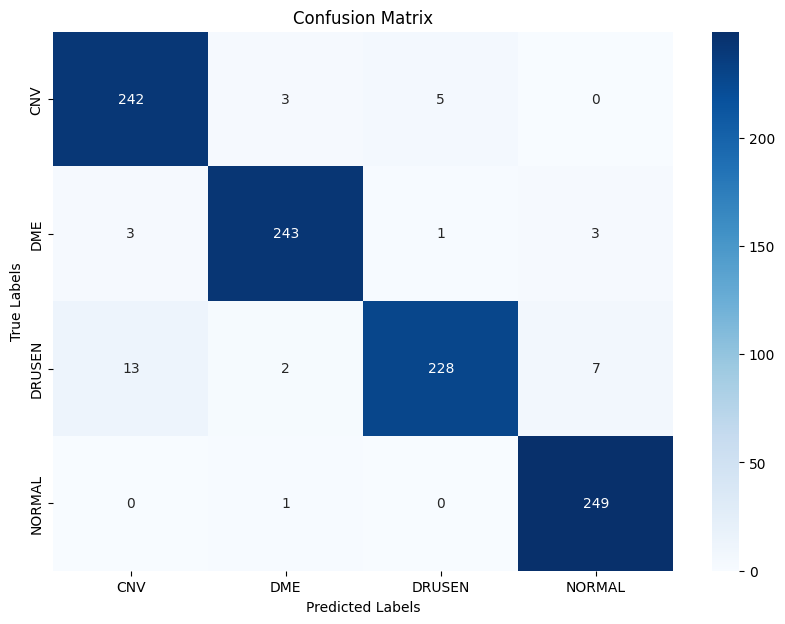

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Given confusion matrix
conf_matrix = np.array([[242, 3, 5, 0],
                        [3, 243, 1, 3],
                        [13, 2, 228, 7],
                        [0, 1, 0, 249]])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['CNV', 'DME', 'DRUSEN', 'NORMAL'],
            yticklabels=['CNV', 'DME', 'DRUSEN', 'NORMAL'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [143]:
test_dataset.classes

['CNV', 'DME', 'DRUSEN', 'NORMAL']

In [144]:
test_dataset.class_to_idx

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

In [87]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate precision, recall, sensitivity, and F1 score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Sensitivity: {recall:.2f}')  # Sensitivity is the same as recall
print(f'F1 Score: {f1:.2f}')
print(f'Confusion Matrix:\n{conf_matrix}')


Accuracy: 95.90%
Precision: 0.96
Recall: 0.96
Sensitivity: 0.96
F1 Score: 0.96
Confusion Matrix:
[[242   3   5   0]
 [  3 245   0   2]
 [ 13   2 224  11]
 [  0   1   1 248]]


In [85]:
import torch
import numpy as np
import random

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [ ]:
95.40

['CNV', 'DME', 'DRUSEN', 'NORMAL']


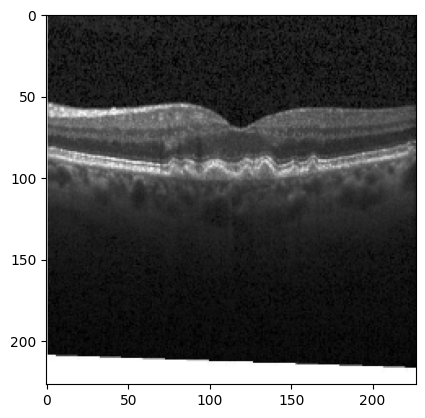

In [32]:
import cv2

print(train_dataset.classes)
img_path = r'OCTDataset\OCT2017Unique\kaggle\working\OCTDataset\OCT2017UniqueSplit\test\DRUSEN\DRUSEN_DRUSEN-364469-137.jpeg'
img = plt.imread(img_path)
img = cv2.resize(img, (227, 227))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

Predicted class: NORMAL


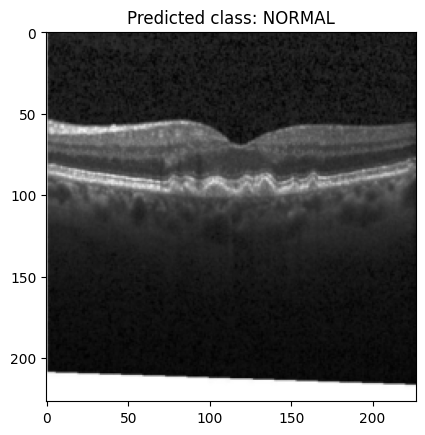

In [35]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Assuming the Model1 class and other necessary classes are defined as per your code

# Load the image
img_path = r'OCTDataset\OCT2017Unique\kaggle\working\OCTDataset\OCT2017UniqueSplit\test\DRUSEN\DRUSEN_DRUSEN-364469-137.jpeg'
image = Image.open(img_path)

# Convert grayscale images to RGB
if image.mode != 'RGB':
    image = image.convert('RGB')

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image = transform(image)
image = image.unsqueeze(0)  # Add batch dimension

# Initialize the model and load the weights
model = Model1(input_shape=(64, 64, 3), num_classes=4)
model.eval()  # Set the model to evaluation mode

# Forward pass through the model
with torch.no_grad():
    output = model(image)
    prediction = torch.argmax(output, dim=1)

# Map the prediction to the class label
class_labels =['CNV', 'DME', 'DRUSEN', 'NORMAL']
predicted_class = class_labels[prediction.item()]

print(f'Predicted class: {predicted_class}')

# Display the image
plt.imshow(image.squeeze().permute(1, 2, 0).numpy())
plt.title(f'Predicted class: {predicted_class}')
plt.show()
